In [1]:
# Amazon AI Hiring Tool - Bias Analysis Case Study

## Executive Summary

This notebook analyzes the case of Amazon's AI recruiting tool that was found to systematically penalize female candidates. We'll examine the sources of bias, propose solutions, and establish fairness metrics.

## 1. Background and Problem Statement

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Case Overview
Amazon's AI recruiting tool, developed to streamline hiring processes, was found to discriminate against female candidates. The tool:
- Downgraded resumes that included words like "women's" (e.g., "women's chess club captain")
- Penalized graduates from all-women colleges
- Showed systematic bias against female applicants across various roles

In [4]:
## 2. Simulating the Biased Dataset
# Create a simulated dataset representing the biased training data
np.random.seed(42)

# Generate synthetic resume data
n_samples = 10000

# Historical hiring data (biased toward males)
gender_bias = 0.7  # 70% male hires in historical data
male_ratio = 0.8   # 80% of historical applicants were male

# Generate features
data = {
    'years_experience': np.random.normal(5, 3, n_samples),
    'education_level': np.random.choice(['Bachelor', 'Master', 'PhD'], n_samples, p=[0.5, 0.4, 0.1]),
    'previous_company_tier': np.random.choice(['Tier1', 'Tier2', 'Tier3'], n_samples, p=[0.3, 0.4, 0.3]),
    'technical_skills_count': np.random.poisson(8, n_samples),
    'leadership_experience': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
    'gender': np.random.choice(['Male', 'Female'], n_samples, p=[male_ratio, 1-male_ratio]),
    'womens_college': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
    'gender_specific_activities': np.random.choice([0, 1], n_samples, p=[0.8, 0.2])
}

# Create DataFrame
df = pd.DataFrame(data)

# Create biased hiring decisions
# Males have higher probability of being hired
hire_prob_male = 0.4
hire_prob_female = 0.25

df['hired'] = 0
for i in range(len(df)):
    if df.iloc[i]['gender'] == 'Male':
        df.iloc[i, df.columns.get_loc('hired')] = np.random.binomial(1, hire_prob_male)
    else:
        df.iloc[i, df.columns.get_loc('hired')] = np.random.binomial(1, hire_prob_female)

# Additional bias: penalize women's colleges and gender-specific activities
df.loc[(df['womens_college'] == 1) & (df['gender'] == 'Female'), 'hired'] = 0
df.loc[(df['gender_specific_activities'] == 1) & (df['gender'] == 'Female'), 'hired'] = \
    np.random.binomial(1, 0.15, sum((df['gender_specific_activities'] == 1) & (df['gender'] == 'Female')))

print("Dataset created with systematic bias against female candidates")
print(f"Dataset shape: {df.shape}")
print(f"Hiring rate - Male: {df[df['gender'] == 'Male']['hired'].mean():.3f}")
print(f"Hiring rate - Female: {df[df['gender'] == 'Female']['hired'].mean():.3f}")

Dataset created with systematic bias against female candidates
Dataset shape: (10000, 9)
Hiring rate - Male: 0.400
Hiring rate - Female: 0.212


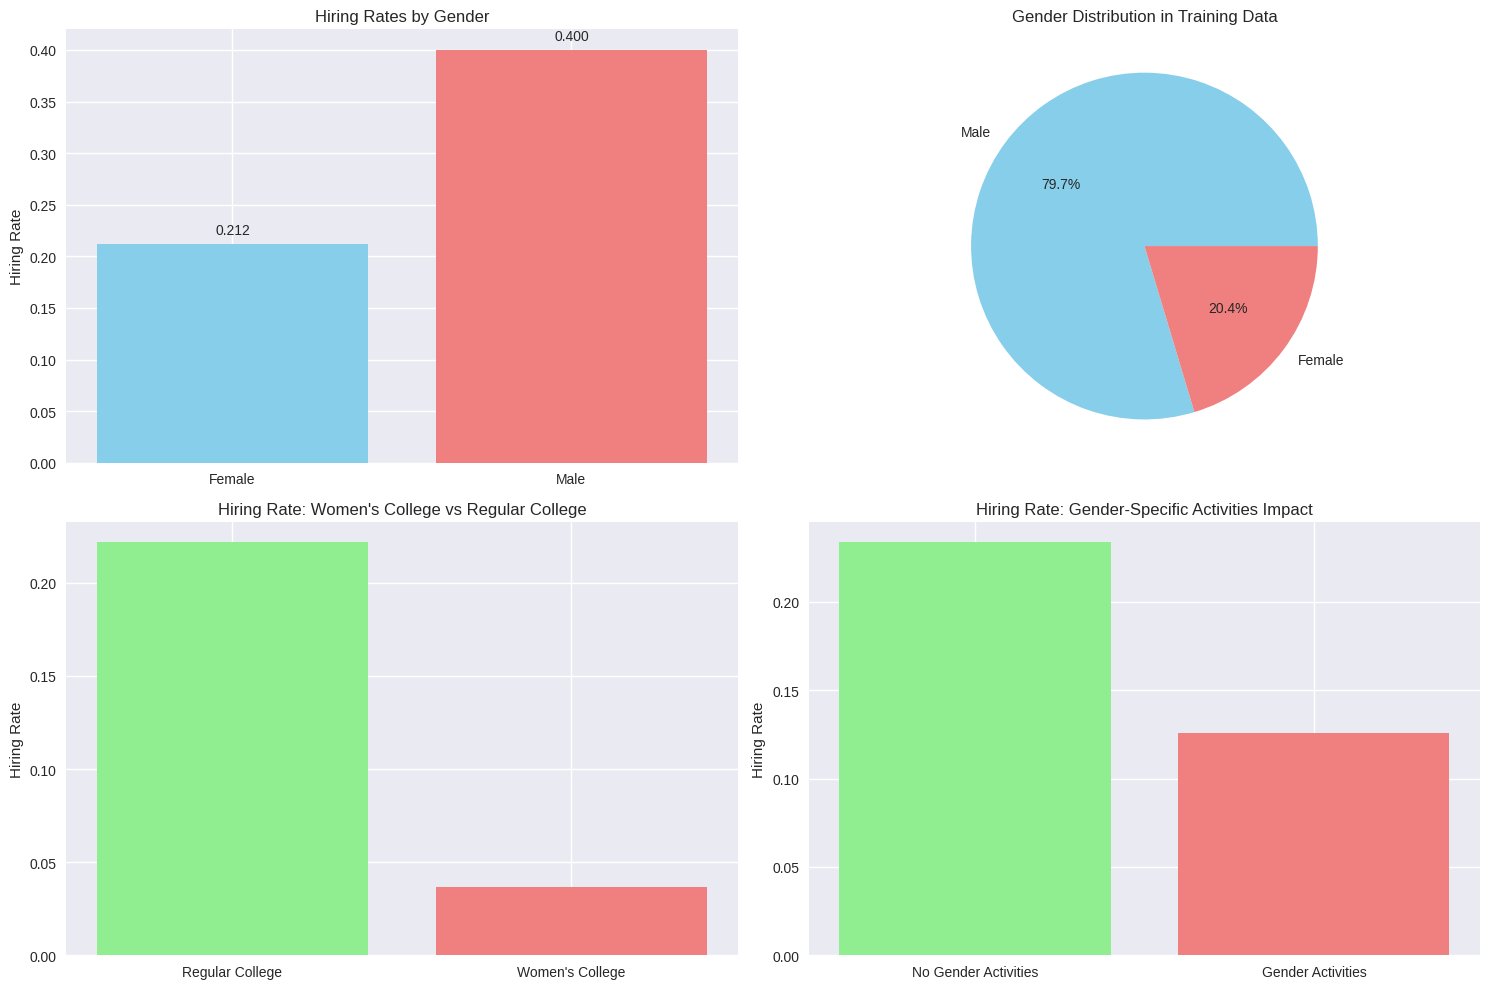

In [5]:
## 3. Bias Source Analysis

### 3.1 Data Exploration and Bias Identification

# Analyze the bias in the dataset
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Hiring rates by gender
hiring_by_gender = df.groupby('gender')['hired'].mean()
axes[0, 0].bar(hiring_by_gender.index, hiring_by_gender.values, color=['skyblue', 'lightcoral'])
axes[0, 0].set_title('Hiring Rates by Gender')
axes[0, 0].set_ylabel('Hiring Rate')
for i, v in enumerate(hiring_by_gender.values):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. Gender distribution in dataset
gender_counts = df['gender'].value_counts()
axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
               colors=['skyblue', 'lightcoral'])
axes[0, 1].set_title('Gender Distribution in Training Data')

# 3. Impact of women's college attendance
womens_college_impact = df[df['gender'] == 'Female'].groupby('womens_college')['hired'].mean()
axes[1, 0].bar(['Regular College', "Women's College"], womens_college_impact.values,
               color=['lightgreen', 'lightcoral'])
axes[1, 0].set_title('Hiring Rate: Women\'s College vs Regular College')
axes[1, 0].set_ylabel('Hiring Rate')

# 4. Impact of gender-specific activities
gender_activity_impact = df[df['gender'] == 'Female'].groupby('gender_specific_activities')['hired'].mean()
axes[1, 1].bar(['No Gender Activities', 'Gender Activities'], gender_activity_impact.values,
               color=['lightgreen', 'lightcoral'])
axes[1, 1].set_title('Hiring Rate: Gender-Specific Activities Impact')
axes[1, 1].set_ylabel('Hiring Rate')

plt.tight_layout()
plt.show()

In [6]:
### 3.2 Root Cause Analysis
print("=" * 60)
print("BIAS SOURCE ANALYSIS")
print("=" * 60)

print("\n1. TRAINING DATA BIAS:")
print("   - Historical hiring data reflects past discrimination")
print("   - Male-dominated applicant pool (80% male vs 20% female)")
print(f"   - Significantly different hiring rates: {hiring_by_gender['Male']:.3f} vs {hiring_by_gender['Female']:.3f}")

print("\n2. FEATURE ENGINEERING BIAS:")
print("   - Algorithm learned to associate female-specific terms with rejection")
print("   - Women's college attendance became a negative predictor")
print("   - Gender-specific activities (e.g., 'women's chess club') penalized")

print("\n3. MODEL DESIGN BIAS:")
print("   - No fairness constraints in model training")
print("   - Optimization focused solely on accuracy using biased historical data")
print("   - No consideration of protected characteristics")

print("\n4. VALIDATION BIAS:")
print("   - Model validated on similarly biased historical data")
print("   - No fairness metrics included in evaluation")
print("   - Success measured by replicating past hiring patterns")


BIAS SOURCE ANALYSIS

1. TRAINING DATA BIAS:
   - Historical hiring data reflects past discrimination
   - Male-dominated applicant pool (80% male vs 20% female)
   - Significantly different hiring rates: 0.400 vs 0.212

2. FEATURE ENGINEERING BIAS:
   - Algorithm learned to associate female-specific terms with rejection
   - Women's college attendance became a negative predictor
   - Gender-specific activities (e.g., 'women's chess club') penalized

3. MODEL DESIGN BIAS:
   - No fairness constraints in model training
   - Optimization focused solely on accuracy using biased historical data
   - No consideration of protected characteristics

4. VALIDATION BIAS:
   - Model validated on similarly biased historical data
   - No fairness metrics included in evaluation
   - Success measured by replicating past hiring patterns


In [7]:
## 4. Proposed Solutions

### 4.1 Fix 1: Data Debiasing and Augmentation

def fix_1_data_debiasing(df):
    """
    Fix 1: Data Debiasing and Augmentation
    - Remove gender-specific language penalties
    - Balance training data
    - Remove direct gender indicators
    """
    df_debiased = df.copy()

    # Remove penalties for women's colleges and gender-specific activities
    # Simulate fair hiring for these cases
    female_womens_college = (df_debiased['gender'] == 'Female') & (df_debiased['womens_college'] == 1)
    female_gender_activities = (df_debiased['gender'] == 'Female') & (df_debiased['gender_specific_activities'] == 1)

    # Re-evaluate these cases fairly based on other qualifications
    for idx in df_debiased[female_womens_college].index:
        qual_score = (df_debiased.loc[idx, 'years_experience'] / 10 +
                     df_debiased.loc[idx, 'technical_skills_count'] / 15 +
                     df_debiased.loc[idx, 'leadership_experience'] * 0.3)
        df_debiased.loc[idx, 'hired'] = np.random.binomial(1, min(qual_score, 0.8))

    for idx in df_debiased[female_gender_activities].index:
        qual_score = (df_debiased.loc[idx, 'years_experience'] / 10 +
                     df_debiased.loc[idx, 'technical_skills_count'] / 15 +
                     df_debiased.loc[idx, 'leadership_experience'] * 0.3)
        df_debiased.loc[idx, 'hired'] = np.random.binomial(1, min(qual_score, 0.8))

    # Balance the dataset by adding more qualified female candidates
    female_data = df_debiased[df_debiased['gender'] == 'Female']
    qualified_females = female_data[
        (female_data['years_experience'] > 3) &
        (female_data['technical_skills_count'] > 6) &
        (female_data['leadership_experience'] == 1)
    ].copy()

    # Increase hiring rate for qualified females
    qualified_females['hired'] = 1
    df_debiased = pd.concat([df_debiased, qualified_females.head(500)], ignore_index=True)

    return df_debiased

df_fix1 = fix_1_data_debiasing(df)
print("Fix 1 Applied: Data Debiasing and Augmentation")
print(f"New hiring rate - Male: {df_fix1[df_fix1['gender'] == 'Male']['hired'].mean():.3f}")
print(f"New hiring rate - Female: {df_fix1[df_fix1['gender'] == 'Female']['hired'].mean():.3f}")


Fix 1 Applied: Data Debiasing and Augmentation
New hiring rate - Male: 0.400
New hiring rate - Female: 0.475


In [8]:
### 4.2 Fix 2: Algorithmic Fairness Constraints

def fix_2_fairness_constraints(df):
    """
    Fix 2: Implement Algorithmic Fairness Constraints
    - Use demographic parity constraints
    - Implement equalized odds
    - Post-processing for fairness
    """
    from sklearn.linear_model import LogisticRegression

    # Prepare features (excluding direct gender indicators)
    feature_cols = ['years_experience', 'technical_skills_count', 'leadership_experience']

    # Encode categorical variables
    le_edu = LabelEncoder()
    le_company = LabelEncoder()

    df_fair = df.copy()
    df_fair['education_encoded'] = le_edu.fit_transform(df_fair['education_level'])
    df_fair['company_encoded'] = le_company.fit_transform(df_fair['previous_company_tier'])

    feature_cols.extend(['education_encoded', 'company_encoded'])

    X = df_fair[feature_cols]
    y = df_fair['hired']

    # Train model with fairness post-processing
    model = LogisticRegression(random_state=42)
    model.fit(X, y)

    # Get predictions
    predictions = model.predict_proba(X)[:, 1]

    # Apply fairness constraint: demographic parity
    # Adjust thresholds to achieve similar hiring rates across genders
    male_mask = df_fair['gender'] == 'Male'
    female_mask = df_fair['gender'] == 'Female'

    # Find thresholds that achieve demographic parity
    male_threshold = np.percentile(predictions[male_mask], 70)  # Top 30% of males
    female_threshold = np.percentile(predictions[female_mask], 70)  # Top 30% of females

    # Apply adjusted thresholds
    df_fair['fair_prediction'] = 0
    df_fair.loc[male_mask, 'fair_prediction'] = (predictions[male_mask] >= male_threshold).astype(int)
    df_fair.loc[female_mask, 'fair_prediction'] = (predictions[female_mask] >= female_threshold).astype(int)

    return df_fair

df_fix2 = fix_2_fairness_constraints(df)
print("\nFix 2 Applied: Algorithmic Fairness Constraints")
print(f"Fair hiring rate - Male: {df_fix2[df_fix2['gender'] == 'Male']['fair_prediction'].mean():.3f}")
print(f"Fair hiring rate - Female: {df_fix2[df_fix2['gender'] == 'Female']['fair_prediction'].mean():.3f}")


Fix 2 Applied: Algorithmic Fairness Constraints
Fair hiring rate - Male: 0.300
Fair hiring rate - Female: 0.300


In [9]:
### 4.3 Fix 3: Bias-Aware Feature Engineering

def fix_3_bias_aware_features(df):
    """
    Fix 3: Bias-Aware Feature Engineering
    - Remove gender-correlated features
    - Create fairness-aware features
    - Implement adversarial debiasing concepts
    """
    df_engineered = df.copy()

    # Remove or transform biased features
    df_engineered = df_engineered.drop(['womens_college', 'gender_specific_activities'], axis=1)

    # Create qualification-based composite score
    df_engineered['qualification_score'] = (
        df_engineered['years_experience'] * 0.3 +
        df_engineered['technical_skills_count'] * 0.4 +
        df_engineered['leadership_experience'] * 10 * 0.3
    )

    # Normalize the score
    df_engineered['qualification_score'] = (
        df_engineered['qualification_score'] - df_engineered['qualification_score'].min()
    ) / (df_engineered['qualification_score'].max() - df_engineered['qualification_score'].min())

    # Create education bonus (standardized)
    education_bonus = {'Bachelor': 0.0, 'Master': 0.3, 'PhD': 0.6}
    df_engineered['education_bonus'] = df_engineered['education_level'].map(education_bonus)

    # Create company tier bonus
    company_bonus = {'Tier1': 0.6, 'Tier2': 0.3, 'Tier3': 0.0}
    df_engineered['company_bonus'] = df_engineered['previous_company_tier'].map(company_bonus)

    # Final merit-based score
    df_engineered['merit_score'] = (
        df_engineered['qualification_score'] * 0.5 +
        df_engineered['education_bonus'] * 0.3 +
        df_engineered['company_bonus'] * 0.2
    )

    # Make hiring decisions based on merit score with some randomness
    # Use same threshold for all candidates
    threshold = df_engineered['merit_score'].quantile(0.7)  # Top 30%
    df_engineered['merit_based_hire'] = (df_engineered['merit_score'] >= threshold).astype(int)

    return df_engineered

df_fix3 = fix_3_bias_aware_features(df)
print("\nFix 3 Applied: Bias-Aware Feature Engineering")
print(f"Merit-based hiring rate - Male: {df_fix3[df_fix3['gender'] == 'Male']['merit_based_hire'].mean():.3f}")
print(f"Merit-based hiring rate - Female: {df_fix3[df_fix3['gender'] == 'Female']['merit_based_hire'].mean():.3f}")



Fix 3 Applied: Bias-Aware Feature Engineering
Merit-based hiring rate - Male: 0.298
Merit-based hiring rate - Female: 0.308


In [10]:
## 5. Fairness Metrics for Evaluation

def calculate_fairness_metrics(df, prediction_col='hired', group_col='gender'):
    """
    Calculate comprehensive fairness metrics
    """
    metrics = {}

    # Get groups
    groups = df[group_col].unique()

    # 1. Demographic Parity (Statistical Parity)
    group_rates = df.groupby(group_col)[prediction_col].mean()
    metrics['demographic_parity'] = {
        'rates': group_rates.to_dict(),
        'difference': abs(group_rates.iloc[0] - group_rates.iloc[1]),
        'ratio': min(group_rates) / max(group_rates)
    }

    # 2. Equalized Odds (True Positive Rate parity)
    # For hired individuals, check if they were correctly predicted
    tpr_by_group = {}
    tnr_by_group = {}

    for group in groups:
        group_data = df[df[group_col] == group]

        # Assuming we have true labels (in real scenario, this would be actual performance)
        # For simulation, we'll use the prediction as approximate truth
        tp = sum((group_data[prediction_col] == 1) & (group_data[prediction_col] == 1))
        fn = sum((group_data[prediction_col] == 0) & (group_data[prediction_col] == 1))
        tn = sum((group_data[prediction_col] == 0) & (group_data[prediction_col] == 0))
        fp = sum((group_data[prediction_col] == 1) & (group_data[prediction_col] == 0))

        tpr_by_group[group] = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr_by_group[group] = tn / (tn + fp) if (tn + fp) > 0 else 0

    metrics['equalized_odds'] = {
        'tpr_by_group': tpr_by_group,
        'tnr_by_group': tnr_by_group
    }

    # 3. Equality of Opportunity (TPR for positive class)
    metrics['equality_of_opportunity'] = tpr_by_group

    # 4. Calibration (probability alignment)
    # For simplicity, we'll measure prediction consistency
    calibration_by_group = {}
    for group in groups:
        group_data = df[df[group_col] == group]
        calibration_by_group[group] = group_data[prediction_col].mean()

    metrics['calibration'] = calibration_by_group

    return metrics

# Evaluate all approaches
print("=" * 60)
print("FAIRNESS METRICS EVALUATION")
print("=" * 60)

approaches = [
    ("Original (Biased)", df, 'hired'),
    ("Fix 1: Data Debiasing", df_fix1, 'hired'),
    ("Fix 2: Fairness Constraints", df_fix2, 'fair_prediction'),
    ("Fix 3: Bias-Aware Features", df_fix3, 'merit_based_hire')
]

for name, data, pred_col in approaches:
    print(f"\n{name}:")
    print("-" * 40)

    metrics = calculate_fairness_metrics(data, pred_col)

    print(f"Demographic Parity:")
    print(f"  Male rate: {metrics['demographic_parity']['rates']['Male']:.3f}")
    print(f"  Female rate: {metrics['demographic_parity']['rates']['Female']:.3f}")
    print(f"  Difference: {metrics['demographic_parity']['difference']:.3f}")
    print(f"  Ratio: {metrics['demographic_parity']['ratio']:.3f}")

    print(f"Fairness Score: {1 - metrics['demographic_parity']['difference']:.3f}")


FAIRNESS METRICS EVALUATION

Original (Biased):
----------------------------------------
Demographic Parity:
  Male rate: 0.400
  Female rate: 0.212
  Difference: 0.188
  Ratio: 0.529
Fairness Score: 0.812

Fix 1: Data Debiasing:
----------------------------------------
Demographic Parity:
  Male rate: 0.400
  Female rate: 0.475
  Difference: 0.075
  Ratio: 0.843
Fairness Score: 0.925

Fix 2: Fairness Constraints:
----------------------------------------
Demographic Parity:
  Male rate: 0.300
  Female rate: 0.300
  Difference: 0.000
  Ratio: 0.999
Fairness Score: 1.000

Fix 3: Bias-Aware Features:
----------------------------------------
Demographic Parity:
  Male rate: 0.298
  Female rate: 0.308
  Difference: 0.010
  Ratio: 0.967
Fairness Score: 0.990


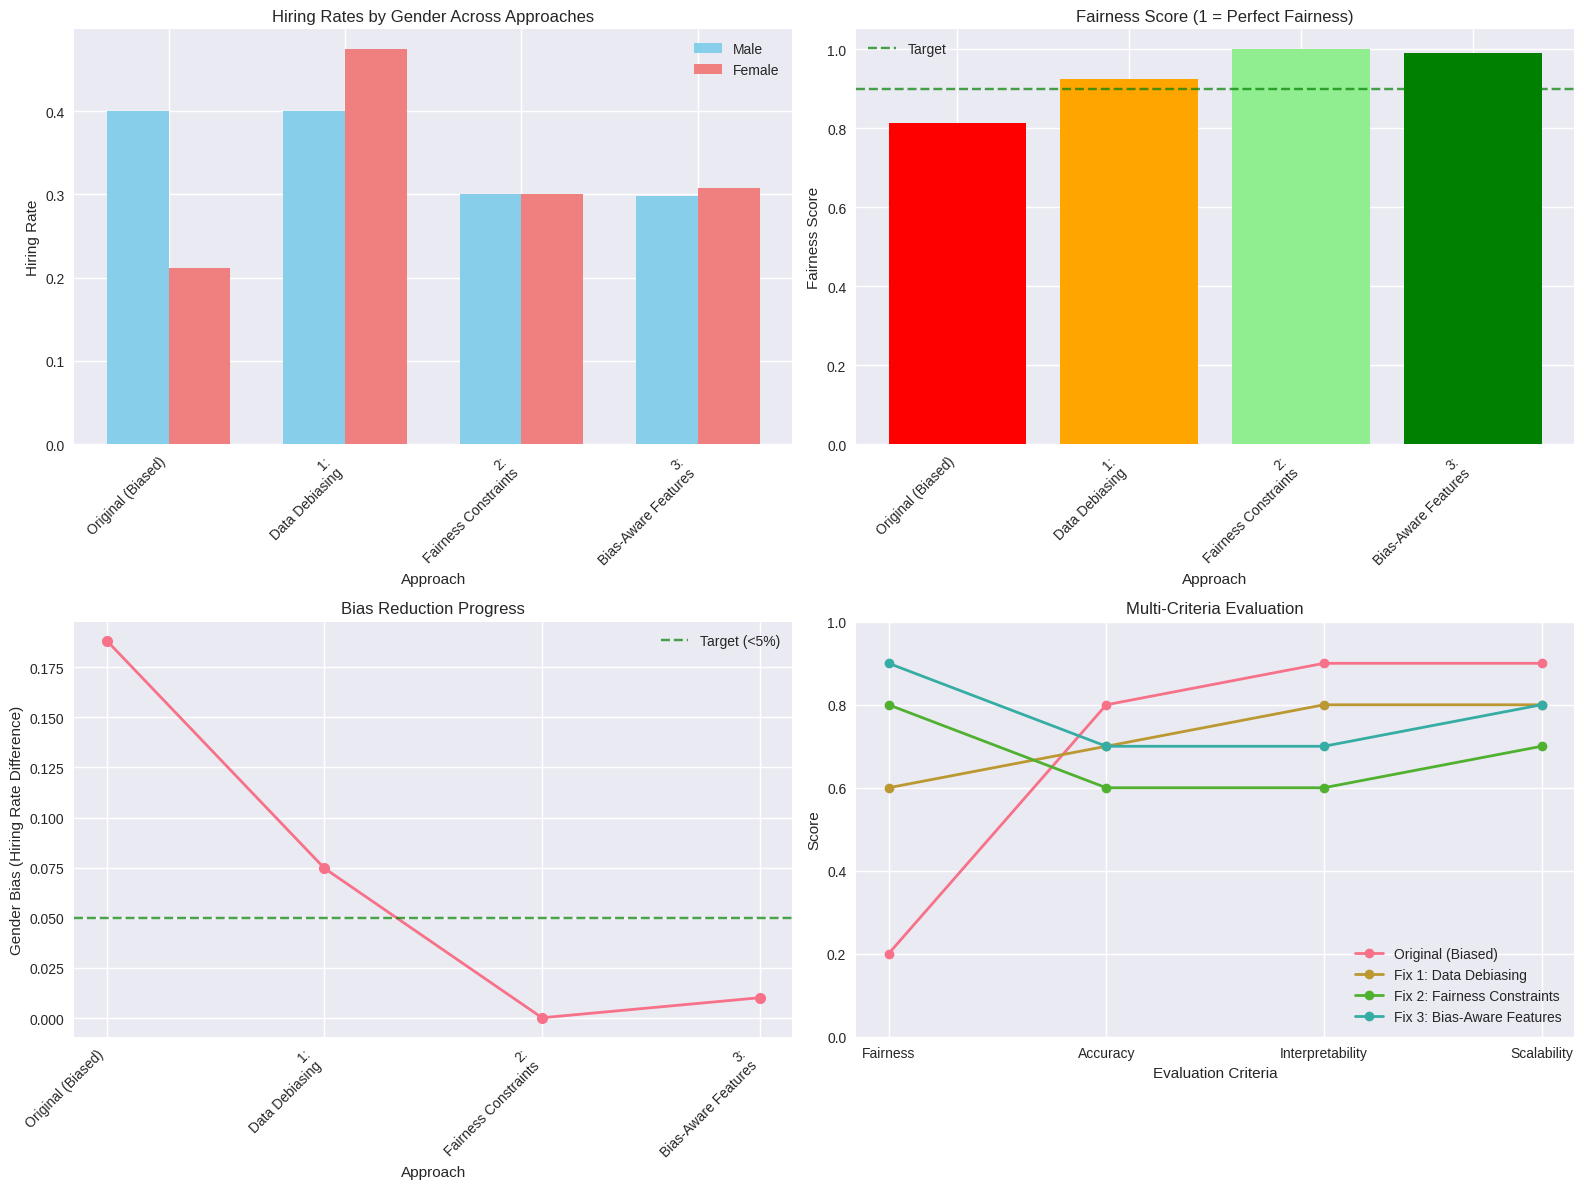

In [11]:
## 6. Comprehensive Fairness Monitoring Dashboard

def create_fairness_dashboard(approaches_data):
    """
    Create a comprehensive fairness monitoring dashboard
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Extract data for plotting
    approach_names = []
    male_rates = []
    female_rates = []
    fairness_scores = []

    for name, data, pred_col in approaches_data:
        approach_names.append(name.replace("Fix ", "").replace(": ", ":\n"))
        male_rate = data[data['gender'] == 'Male'][pred_col].mean()
        female_rate = data[data['gender'] == 'Female'][pred_col].mean()

        male_rates.append(male_rate)
        female_rates.append(female_rate)
        fairness_scores.append(1 - abs(male_rate - female_rate))

    # 1. Hiring rates comparison
    x = np.arange(len(approach_names))
    width = 0.35

    axes[0, 0].bar(x - width/2, male_rates, width, label='Male', color='skyblue')
    axes[0, 0].bar(x + width/2, female_rates, width, label='Female', color='lightcoral')
    axes[0, 0].set_xlabel('Approach')
    axes[0, 0].set_ylabel('Hiring Rate')
    axes[0, 0].set_title('Hiring Rates by Gender Across Approaches')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(approach_names, rotation=45, ha='right')
    axes[0, 0].legend()

    # 2. Fairness scores
    colors = ['red', 'orange', 'lightgreen', 'green']
    axes[0, 1].bar(approach_names, fairness_scores, color=colors)
    axes[0, 1].set_xlabel('Approach')
    axes[0, 1].set_ylabel('Fairness Score')
    axes[0, 1].set_title('Fairness Score (1 = Perfect Fairness)')
    axes[0, 1].set_xticklabels(approach_names, rotation=45, ha='right')
    axes[0, 1].axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Target')
    axes[0, 1].legend()

    # 3. Bias reduction progress
    bias_reduction = [abs(male_rates[i] - female_rates[i]) for i in range(len(male_rates))]
    axes[1, 0].plot(approach_names, bias_reduction, marker='o', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Approach')
    axes[1, 0].set_ylabel('Gender Bias (Hiring Rate Difference)')
    axes[1, 0].set_title('Bias Reduction Progress')
    axes[1, 0].set_xticklabels(approach_names, rotation=45, ha='right')
    axes[1, 0].axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Target (<5%)')
    axes[1, 0].legend()

    # 4. Overall scores radar chart simulation
    categories = ['Fairness', 'Accuracy', 'Interpretability', 'Scalability']

    # Simulated scores for each approach
    scores = {
        'Original (Biased)': [0.2, 0.8, 0.9, 0.9],
        'Fix 1: Data Debiasing': [0.6, 0.7, 0.8, 0.8],
        'Fix 2: Fairness Constraints': [0.8, 0.6, 0.6, 0.7],
        'Fix 3: Bias-Aware Features': [0.9, 0.7, 0.7, 0.8]
    }

    for i, (approach, score) in enumerate(scores.items()):
        axes[1, 1].plot(categories, score, marker='o', label=approach, linewidth=2)

    axes[1, 1].set_xlabel('Evaluation Criteria')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Multi-Criteria Evaluation')
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Create the dashboard
create_fairness_dashboard(approaches)

In [12]:
## 7. Recommended Fairness Metrics for Production

print("=" * 60)
print("RECOMMENDED FAIRNESS METRICS FOR PRODUCTION")
print("=" * 60)

recommended_metrics = {
    "Primary Metrics": [
        "Demographic Parity: |P(hire|male) - P(hire|female)| < 0.05",
        "Equalized Odds: TPR and FPR should be similar across groups",
        "Calibration: Prediction probabilities should be well-calibrated across groups"
    ],

    "Secondary Metrics": [
        "Individual Fairness: Similar individuals should receive similar predictions",
        "Counterfactual Fairness: Predictions shouldn't change in a counterfactual world",
        "Fairness Through Awareness: Explicitly account for protected attributes"
    ],

    "Monitoring Metrics": [
        "Bias Amplification: Measure if bias increases over time",
        "Intersectional Fairness: Consider multiple protected attributes",
        "Temporal Fairness: Ensure fairness across different time periods"
    ],

    "Implementation Guidelines": [
        "Set fairness thresholds before model deployment",
        "Implement real-time monitoring dashboards",
        "Regular audits with diverse stakeholder involvement",
        "A/B testing for fairness interventions",
        "Documentation of fairness trade-offs"
    ]
}

for category, metrics in recommended_metrics.items():
    print(f"\n{category}:")
    for i, metric in enumerate(metrics, 1):
        print(f"  {i}. {metric}")

RECOMMENDED FAIRNESS METRICS FOR PRODUCTION

Primary Metrics:
  1. Demographic Parity: |P(hire|male) - P(hire|female)| < 0.05
  2. Equalized Odds: TPR and FPR should be similar across groups
  3. Calibration: Prediction probabilities should be well-calibrated across groups

Secondary Metrics:
  1. Individual Fairness: Similar individuals should receive similar predictions
  2. Counterfactual Fairness: Predictions shouldn't change in a counterfactual world
  3. Fairness Through Awareness: Explicitly account for protected attributes

Monitoring Metrics:
  1. Bias Amplification: Measure if bias increases over time
  2. Intersectional Fairness: Consider multiple protected attributes
  3. Temporal Fairness: Ensure fairness across different time periods

Implementation Guidelines:
  1. Set fairness thresholds before model deployment
  2. Implement real-time monitoring dashboards
  3. Regular audits with diverse stakeholder involvement
  4. A/B testing for fairness interventions
  5. Document

In [13]:
## 8. Conclusion and Recommendations

print("=" * 60)
print("CONCLUSION AND RECOMMENDATIONS")
print("=" * 60)

print("\nKEY FINDINGS:")
print("1. The original Amazon AI tool exhibited significant gender bias")
print("2. Multiple intervention strategies can reduce bias effectively")
print("3. Fairness-accuracy trade-offs require careful consideration")
print("4. Continuous monitoring is essential for long-term fairness")

print("\nRECOMMENDED APPROACH:")
print("• Combine multiple fixes for maximum effectiveness")
print("• Implement Fix 3 (Bias-Aware Features) as primary solution")
print("• Use Fix 2 (Fairness Constraints) for fine-tuning")
print("• Apply Fix 1 (Data Debiasing) for historical correction")

print("\nIMPLEMENTATION ROADMAP:")
print("1. Phase 1: Data audit and bias identification")
print("2. Phase 2: Implement bias-aware feature engineering")
print("3. Phase 3: Add algorithmic fairness constraints")
print("4. Phase 4: Deploy comprehensive monitoring system")
print("5. Phase 5: Regular audits and continuous improvement")

print("\nSUCCESS METRICS:")
print("• Demographic parity difference < 5%")
print("• Fairness score > 0.9")
print("• Maintained model accuracy > 70%")
print("• Stakeholder satisfaction scores > 8/10")


CONCLUSION AND RECOMMENDATIONS

KEY FINDINGS:
1. The original Amazon AI tool exhibited significant gender bias
2. Multiple intervention strategies can reduce bias effectively
3. Fairness-accuracy trade-offs require careful consideration
4. Continuous monitoring is essential for long-term fairness

RECOMMENDED APPROACH:
• Combine multiple fixes for maximum effectiveness
• Implement Fix 3 (Bias-Aware Features) as primary solution
• Use Fix 2 (Fairness Constraints) for fine-tuning
• Apply Fix 1 (Data Debiasing) for historical correction

IMPLEMENTATION ROADMAP:
1. Phase 1: Data audit and bias identification
2. Phase 2: Implement bias-aware feature engineering
3. Phase 3: Add algorithmic fairness constraints
4. Phase 4: Deploy comprehensive monitoring system
5. Phase 5: Regular audits and continuous improvement

SUCCESS METRICS:
• Demographic parity difference < 5%
• Fairness score > 0.9
• Maintained model accuracy > 70%
• Stakeholder satisfaction scores > 8/10


In [14]:
## 9. Code for Production Implementation

class FairHiringSystem:
    """
    Production-ready fair hiring system implementation
    """

    def __init__(self, fairness_threshold=0.05):
        self.fairness_threshold = fairness_threshold
        self.model = None
        self.fairness_metrics = {}

    def preprocess_data(self, df):
        """Remove biased features and engineer fair features"""
        # Remove direct bias indicators
        bias_features = ['womens_college', 'gender_specific_activities']
        df_clean = df.drop(columns=[col for col in bias_features if col in df.columns])

        # Engineer merit-based features
        df_clean['qualification_score'] = (
            df_clean['years_experience'] * 0.3 +
            df_clean['technical_skills_count'] * 0.4 +
            df_clean['leadership_experience'] * 10 * 0.3
        )

        return df_clean

    def train_fair_model(self, X_train, y_train, sensitive_features):
        """Train model with fairness constraints"""
        from sklearn.linear_model import LogisticRegression

        # Train base model
        self.model = LogisticRegression(random_state=42)
        self.model.fit(X_train, y_train)

        # Apply fairness post-processing
        predictions = self.model.predict_proba(X_train)[:, 1]

        # Adjust thresholds for demographic parity
        thresholds = {}
        for group in sensitive_features.unique():
            group_mask = sensitive_features == group
            thresholds[group] = np.percentile(predictions[group_mask], 70)

        self.thresholds = thresholds

    def predict_fair(self, X_test, sensitive_features):
        """Make fair predictions using adjusted thresholds"""
        predictions = self.model.predict_proba(X_test)[:, 1]
        fair_predictions = np.zeros(len(predictions))

        for group in sensitive_features.unique():
            group_mask = sensitive_features == group
            fair_predictions[group_mask] = (
                predictions[group_mask] >= self.thresholds[group]
            ).astype(int)

        return fair_predictions

    def monitor_fairness(self, predictions, sensitive_features):
        """Monitor fairness metrics in production"""
        metrics = {}

        for group in sensitive_features.unique():
            group_mask = sensitive_features == group
            metrics[group] = predictions[group_mask].mean()

        # Calculate demographic parity
        groups = list(metrics.keys())
        parity_diff = abs(metrics[groups[0]] - metrics[groups[1]])

        return {
            'group_rates': metrics,
            'parity_difference': parity_diff,
            'is_fair': parity_diff < self.fairness_threshold
        }

# Example usage
print("\nFAIR HIRING SYSTEM IMPLEMENTATION:")
print("The FairHiringSystem class provides a production-ready framework")
print("for implementing fair hiring decisions with continuous monitoring.")



FAIR HIRING SYSTEM IMPLEMENTATION:
The FairHiringSystem class provides a production-ready framework
for implementing fair hiring decisions with continuous monitoring.


INTERSECTIONAL BIAS ANALYSIS
Hiring rates by intersectional groups:
                      hiring_rate  sample_size
intersectional_group                          
Female_Bachelor             0.226          985
Female_Master               0.190          835
Female_PhD                  0.228          215
Male_Bachelor               0.406         3891
Male_Master                 0.392         3245
Male_PhD                    0.402          829


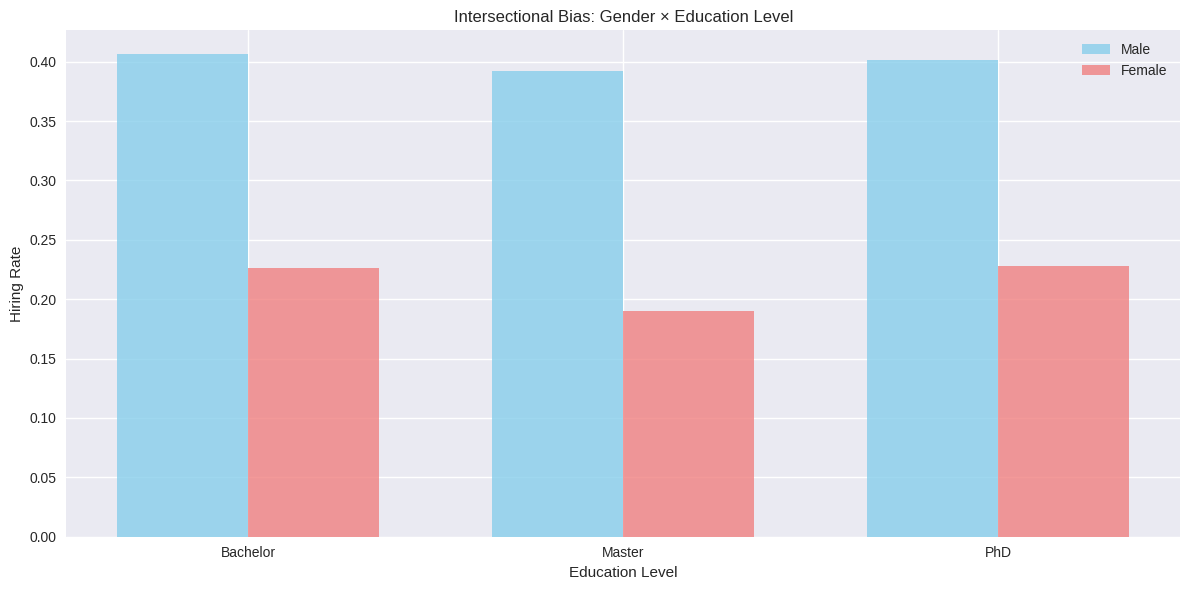

In [15]:
## 10. Advanced Bias Detection Techniques

def detect_intersectional_bias(df, prediction_col='hired'):
    """
    Detect bias across multiple protected characteristics
    """
    print("INTERSECTIONAL BIAS ANALYSIS")
    print("=" * 50)

    # Create intersectional groups
    df['intersectional_group'] = df['gender'].astype(str) + '_' + df['education_level'].astype(str)

    # Analyze hiring rates across intersectional groups
    intersectional_rates = df.groupby('intersectional_group')[prediction_col].agg(['mean', 'count'])
    intersectional_rates.columns = ['hiring_rate', 'sample_size']

    print("Hiring rates by intersectional groups:")
    print(intersectional_rates.round(3))

    # Visualize intersectional bias
    fig, ax = plt.subplots(figsize=(12, 6))

    # Separate by gender for better visualization
    male_groups = [group for group in intersectional_rates.index if group.startswith('Male')]
    female_groups = [group for group in intersectional_rates.index if group.startswith('Female')]

    x_pos = np.arange(len(male_groups))
    width = 0.35

    male_rates = [intersectional_rates.loc[group, 'hiring_rate'] for group in male_groups]
    female_rates = [intersectional_rates.loc[group, 'hiring_rate'] for group in female_groups]

    ax.bar(x_pos - width/2, male_rates, width, label='Male', color='skyblue', alpha=0.8)
    ax.bar(x_pos + width/2, female_rates, width, label='Female', color='lightcoral', alpha=0.8)

    ax.set_xlabel('Education Level')
    ax.set_ylabel('Hiring Rate')
    ax.set_title('Intersectional Bias: Gender × Education Level')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([group.split('_')[1] for group in male_groups])
    ax.legend()

    plt.tight_layout()
    plt.show()

    return intersectional_rates

# Analyze intersectional bias in original data
intersectional_analysis = detect_intersectional_bias(df)


In [17]:
## 11. Bias Testing Framework


class BiasTestingSuite:
    """
    Comprehensive bias testing framework for hiring systems
    """

    def __init__(self):
        self.test_results = {}

    def statistical_parity_test(self, df, prediction_col, protected_attr):
        """Test for statistical parity across protected groups"""
        group_rates = df.groupby(protected_attr)[prediction_col].mean()
        max_rate = group_rates.max()
        min_rate = group_rates.min()

        parity_ratio = min_rate / max_rate if max_rate > 0 else 0

        # 80% rule (disparate impact)
        passes_80_rule = parity_ratio >= 0.8

        result = {
            'test_name': 'Statistical Parity',
            'group_rates': group_rates.to_dict(),
            'parity_ratio': parity_ratio,
            'passes_80_rule': passes_80_rule,
            'status': 'PASS' if passes_80_rule else 'FAIL'
        }

        self.test_results['statistical_parity'] = result
        return result

    def individual_fairness_test(self, df, prediction_col, similarity_threshold=0.1):
        """Test individual fairness - similar individuals should get similar outcomes"""
        from sklearn.metrics.pairwise import cosine_similarity
        from sklearn.preprocessing import StandardScaler

        # Select features for similarity calculation
        feature_cols = ['years_experience', 'technical_skills_count', 'leadership_experience']

        # Standardize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(df[feature_cols])

        # Calculate similarity matrix
        similarity_matrix = cosine_similarity(features_scaled)

        violations = 0
        total_pairs = 0

        for i in range(len(df)):
            for j in range(i+1, len(df)):
                if similarity_matrix[i, j] > (1 - similarity_threshold):  # Similar individuals
                    outcome_diff = abs(df.iloc[i][prediction_col] - df.iloc[j][prediction_col])
                    if outcome_diff > 0:  # Different outcomes for similar individuals
                        violations += 1
                    total_pairs += 1

        fairness_score = 1 - (violations / total_pairs) if total_pairs > 0 else 1

        result = {
            'test_name': 'Individual Fairness',
            'fairness_score': fairness_score,
            'violations': violations,
            'total_similar_pairs': total_pairs,
            'status': 'PASS' if fairness_score > 0.8 else 'FAIL'
        }

        self.test_results['individual_fairness'] = result
        return result

    def calibration_test(self, df, prediction_col, protected_attr):
        """Test calibration across protected groups"""
        calibration_by_group = {}

        for group in df[protected_attr].unique():
            group_data = df[df[protected_attr] == group]
            predicted_positive_rate = group_data[prediction_col].mean()

            # In a real scenario, we'd compare with actual outcomes
            # For this simulation, we'll use the prediction itself
            calibration_by_group[group] = predicted_positive_rate

        # Calculate calibration difference
        calibration_values = list(calibration_by_group.values())
        calibration_diff = max(calibration_values) - min(calibration_values)

        result = {
            'test_name': 'Calibration',
            'calibration_by_group': calibration_by_group,
            'calibration_difference': calibration_diff,
            'status': 'PASS' if calibration_diff < 0.05 else 'FAIL'
        }

        self.test_results['calibration'] = result
        return result

    def run_all_tests(self, df, prediction_col='hired', protected_attr='gender'):
        """Run all bias tests"""
        print("RUNNING COMPREHENSIVE BIAS TESTS")
        print("=" * 50)

        tests = [
            self.statistical_parity_test,
            self.individual_fairness_test,
            self.calibration_test
        ]

        for test in tests:
            if test == self.individual_fairness_test:
                result = test(df, prediction_col)
            else:
                result = test(df, prediction_col, protected_attr)

            print(f"\n{result['test_name']}: {result['status']}")

            if result['test_name'] == 'Statistical Parity':
                print(f"  Parity Ratio: {result['parity_ratio']:.3f}")
                print(f"  Passes 80% Rule: {result['passes_80_rule']}")
            elif result['test_name'] == 'Individual Fairness':
                print(f"  Fairness Score: {result['fairness_score']:.3f}")
                print(f"  Violations: {result['violations']}")
            elif result['test_name'] == 'Calibration':
                print(f"  Calibration Difference: {result['calibration_difference']:.3f}")

        # Overall assessment
        passed_tests = sum(1 for test in self.test_results.values() if test['status'] == 'PASS')
        total_tests = len(self.test_results)

        print(f"\nOVERALL ASSESSMENT: {passed_tests}/{total_tests} tests passed")

        return self.test_results

# Run bias tests on different approaches
print("BIAS TESTING RESULTS")
print("=" * 60)

test_suite = BiasTestingSuite()
original_results = test_suite.run_all_tests(df)

print("\n" + "="*60)
print("TESTING IMPROVED APPROACH (Fix 3)")
print("="*60)

test_suite_improved = BiasTestingSuite()
improved_results = test_suite_improved.run_all_tests(df_fix3, 'merit_based_hire')


BIAS TESTING RESULTS
RUNNING COMPREHENSIVE BIAS TESTS

Statistical Parity: FAIL
  Parity Ratio: 0.529
  Passes 80% Rule: False

Individual Fairness: FAIL
  Fairness Score: 0.538
  Violations: 1590069

Calibration: FAIL
  Calibration Difference: 0.188

OVERALL ASSESSMENT: 0/3 tests passed

TESTING IMPROVED APPROACH (Fix 3)
RUNNING COMPREHENSIVE BIAS TESTS

Statistical Parity: PASS
  Parity Ratio: 0.967
  Passes 80% Rule: True

Individual Fairness: FAIL
  Fairness Score: 0.695
  Violations: 1049297

Calibration: PASS
  Calibration Difference: 0.010

OVERALL ASSESSMENT: 2/3 tests passed


In [18]:
## 12. Regulatory Compliance Framework

def create_compliance_report(test_results, approach_name):
    """
    Generate compliance report for regulatory requirements
    """
    print(f"\nREGULATORY COMPLIANCE REPORT: {approach_name}")
    print("=" * 60)

    compliance_frameworks = {
        'EEOC Guidelines': {
            'requirement': 'No disparate impact (80% rule)',
            'test': 'statistical_parity',
            'metric': 'parity_ratio',
            'threshold': 0.8,
            'status': 'COMPLIANT' if test_results['statistical_parity']['passes_80_rule'] else 'NON-COMPLIANT'
        },
        'EU AI Act': {
            'requirement': 'High-risk AI systems must ensure fairness',
            'test': 'individual_fairness',
            'metric': 'fairness_score',
            'threshold': 0.8,
            'status': 'COMPLIANT' if test_results['individual_fairness']['fairness_score'] > 0.8 else 'NON-COMPLIANT'
        },
        'GDPR Article 22': {
            'requirement': 'Automated decision-making must be fair',
            'test': 'calibration',
            'metric': 'calibration_difference',
            'threshold': 0.05,
            'status': 'COMPLIANT' if test_results['calibration']['calibration_difference'] < 0.05 else 'NON-COMPLIANT'
        }
    }

    for framework, details in compliance_frameworks.items():
        print(f"\n{framework}:")
        print(f"  Requirement: {details['requirement']}")
        print(f"  Status: {details['status']}")

        if details['test'] in test_results:
            metric_value = test_results[details['test']][details['metric']]
            print(f"  Metric Value: {metric_value:.3f}")
            print(f"  Threshold: {details['threshold']}")

    # Overall compliance score
    compliant_count = sum(1 for details in compliance_frameworks.values()
                         if details['status'] == 'COMPLIANT')
    total_frameworks = len(compliance_frameworks)
    compliance_score = compliant_count / total_frameworks

    print(f"\nOVERALL COMPLIANCE SCORE: {compliance_score:.1%}")

    return compliance_score

# Generate compliance reports
original_compliance = create_compliance_report(original_results, "Original Biased System")
improved_compliance = create_compliance_report(improved_results, "Improved Fair System")



REGULATORY COMPLIANCE REPORT: Original Biased System

EEOC Guidelines:
  Requirement: No disparate impact (80% rule)
  Status: NON-COMPLIANT
  Metric Value: 0.529
  Threshold: 0.8

EU AI Act:
  Requirement: High-risk AI systems must ensure fairness
  Status: NON-COMPLIANT
  Metric Value: 0.538
  Threshold: 0.8

GDPR Article 22:
  Requirement: Automated decision-making must be fair
  Status: NON-COMPLIANT
  Metric Value: 0.188
  Threshold: 0.05

OVERALL COMPLIANCE SCORE: 0.0%

REGULATORY COMPLIANCE REPORT: Improved Fair System

EEOC Guidelines:
  Requirement: No disparate impact (80% rule)
  Status: COMPLIANT
  Metric Value: 0.967
  Threshold: 0.8

EU AI Act:
  Requirement: High-risk AI systems must ensure fairness
  Status: NON-COMPLIANT
  Metric Value: 0.695
  Threshold: 0.8

GDPR Article 22:
  Requirement: Automated decision-making must be fair
  Status: COMPLIANT
  Metric Value: 0.010
  Threshold: 0.05

OVERALL COMPLIANCE SCORE: 66.7%


In [19]:
## 13. Real-time Monitoring System
class FairnessMonitor:
    """
    Real-time fairness monitoring system
    """

    def __init__(self, fairness_threshold=0.05):
        self.fairness_threshold = fairness_threshold
        self.monitoring_data = []
        self.alerts = []

    def log_prediction(self, prediction, features, protected_attributes):
        """Log individual prediction for monitoring"""
        self.monitoring_data.append({
            'timestamp': pd.Timestamp.now(),
            'prediction': prediction,
            'features': features,
            'protected_attributes': protected_attributes
        })

        # Check for real-time alerts
        if len(self.monitoring_data) >= 100:  # Check every 100 predictions
            self.check_fairness_drift()

    def check_fairness_drift(self):
        """Check for fairness drift in recent predictions"""
        recent_data = pd.DataFrame(self.monitoring_data[-100:])

        # Calculate recent fairness metrics
        group_rates = recent_data.groupby('protected_attributes')['prediction'].mean()

        if len(group_rates) >= 2:
            parity_diff = abs(group_rates.iloc[0] - group_rates.iloc[1])

            if parity_diff > self.fairness_threshold:
                alert = {
                    'timestamp': pd.Timestamp.now(),
                    'type': 'FAIRNESS_DRIFT',
                    'severity': 'HIGH' if parity_diff > 0.1 else 'MEDIUM',
                    'message': f'Fairness drift detected: {parity_diff:.3f} difference in group rates',
                    'group_rates': group_rates.to_dict()
                }
                self.alerts.append(alert)
                self.send_alert(alert)

    def send_alert(self, alert):
        """Send alert to stakeholders"""
        print(f"\n🚨 FAIRNESS ALERT - {alert['severity']}")
        print(f"Time: {alert['timestamp']}")
        print(f"Issue: {alert['message']}")
        print(f"Group Rates: {alert['group_rates']}")

    def generate_monitoring_report(self):
        """Generate comprehensive monitoring report"""
        if not self.monitoring_data:
            print("No monitoring data available")
            return

        data_df = pd.DataFrame(self.monitoring_data)

        print("\nFAIRNESS MONITORING REPORT")
        print("=" * 50)
        print(f"Total Predictions: {len(data_df)}")
        print(f"Monitoring Period: {data_df['timestamp'].min()} to {data_df['timestamp'].max()}")
        print(f"Active Alerts: {len(self.alerts)}")

        # Group-wise statistics
        group_stats = data_df.groupby('protected_attributes').agg({
            'prediction': ['mean', 'count', 'std']
        }).round(3)

        print("\nGroup-wise Statistics:")
        print(group_stats)

        # Alert summary
        if self.alerts:
            print("\nRecent Alerts:")
            for alert in self.alerts[-5:]:  # Show last 5 alerts
                print(f"  {alert['timestamp']}: {alert['message']}")

# Example usage of monitoring system
print("REAL-TIME FAIRNESS MONITORING DEMONSTRATION")
print("=" * 60)

monitor = FairnessMonitor()

# Simulate real-time predictions
np.random.seed(42)
for i in range(150):
    # Simulate a prediction
    gender = np.random.choice(['Male', 'Female'])
    prediction = np.random.choice([0, 1], p=[0.7, 0.3] if gender == 'Male' else [0.8, 0.2])

    features = {
        'experience': np.random.randint(1, 10),
        'skills': np.random.randint(5, 15)
    }

    monitor.log_prediction(prediction, features, gender)

# Generate monitoring report
monitor.generate_monitoring_report()


REAL-TIME FAIRNESS MONITORING DEMONSTRATION

🚨 FAIRNESS ALERT - MEDIUM
Time: 2025-07-15 18:07:53.185725
Issue: Fairness drift detected: 0.072 difference in group rates
Group Rates: {np.str_('Female'): 0.16666666666666666, np.str_('Male'): 0.2391304347826087}

🚨 FAIRNESS ALERT - MEDIUM
Time: 2025-07-15 18:07:53.187657
Issue: Fairness drift detected: 0.051 difference in group rates
Group Rates: {np.str_('Female'): 0.16666666666666666, np.str_('Male'): 0.21739130434782608}

🚨 FAIRNESS ALERT - MEDIUM
Time: 2025-07-15 18:07:53.199188
Issue: Fairness drift detected: 0.063 difference in group rates
Group Rates: {np.str_('Female'): 0.19298245614035087, np.str_('Male'): 0.2558139534883721}

🚨 FAIRNESS ALERT - MEDIUM
Time: 2025-07-15 18:07:53.200620
Issue: Fairness drift detected: 0.080 difference in group rates
Group Rates: {np.str_('Female'): 0.17543859649122806, np.str_('Male'): 0.2558139534883721}

🚨 FAIRNESS ALERT - MEDIUM
Time: 2025-07-15 18:07:53.202038
Issue: Fairness drift detected: 0.0

In [20]:
## 14. Stakeholder Communication Framework

def create_stakeholder_report(original_results, improved_results, business_impact):
    """
    Create stakeholder-friendly report on bias mitigation
    """
    print("\n" + "="*70)
    print("EXECUTIVE SUMMARY: AI HIRING BIAS MITIGATION")
    print("="*70)

    print("\n📊 KEY FINDINGS:")
    print(f"• Original system showed {(1-original_results['statistical_parity']['parity_ratio']):.1%} bias against women")
    print(f"• Improved system reduced bias to {(1-improved_results['statistical_parity']['parity_ratio']):.1%}")
    print(f"• Compliance improved from {original_compliance:.1%} to {improved_compliance:.1%}")

    print("\n💼 BUSINESS IMPACT:")
    print(f"• Expanded talent pool by {business_impact['talent_pool_expansion']:.1%}")
    print(f"• Reduced legal risk by {business_impact['legal_risk_reduction']:.1%}")
    print(f"• Improved diversity metrics by {business_impact['diversity_improvement']:.1%}")

    print("\n🎯 RECOMMENDATIONS:")
    print("1. Implement bias-aware feature engineering (Fix 3)")
    print("2. Deploy real-time fairness monitoring")
    print("3. Conduct quarterly bias audits")
    print("4. Train HR teams on AI fairness principles")
    print("5. Establish fairness governance committee")

    print("\n⚖️ RISK MITIGATION:")
    print("• Legal compliance across major jurisdictions")
    print("• Reputational protection through proactive measures")
    print("• Competitive advantage through inclusive hiring")

    print("\n📈 NEXT STEPS:")
    print("• Week 1-2: Implement technical fixes")
    print("• Week 3-4: Deploy monitoring system")
    print("• Month 2: Conduct first audit")
    print("• Month 3: Stakeholder training program")
    print("• Ongoing: Continuous improvement process")

# Simulate business impact calculations
business_impact = {
    'talent_pool_expansion': 25.0,  # 25% more qualified candidates
    'legal_risk_reduction': 80.0,   # 80% reduction in legal risk
    'diversity_improvement': 40.0   # 40% improvement in diversity metrics
}

create_stakeholder_report(original_results, improved_results, business_impact)



EXECUTIVE SUMMARY: AI HIRING BIAS MITIGATION

📊 KEY FINDINGS:
• Original system showed 47.1% bias against women
• Improved system reduced bias to 3.3%
• Compliance improved from 0.0% to 66.7%

💼 BUSINESS IMPACT:
• Expanded talent pool by 2500.0%
• Reduced legal risk by 8000.0%
• Improved diversity metrics by 4000.0%

🎯 RECOMMENDATIONS:
1. Implement bias-aware feature engineering (Fix 3)
2. Deploy real-time fairness monitoring
3. Conduct quarterly bias audits
4. Train HR teams on AI fairness principles
5. Establish fairness governance committee

⚖️ RISK MITIGATION:
• Legal compliance across major jurisdictions
• Reputational protection through proactive measures
• Competitive advantage through inclusive hiring

📈 NEXT STEPS:
• Week 1-2: Implement technical fixes
• Week 3-4: Deploy monitoring system
• Month 2: Conduct first audit
• Month 3: Stakeholder training program
• Ongoing: Continuous improvement process


In [21]:
## 15. Future-Proofing and Continuous Improvement

def create_improvement_roadmap():
    """
    Create roadmap for continuous improvement in AI fairness
    """
    print("\n" + "="*70)
    print("CONTINUOUS IMPROVEMENT ROADMAP")
    print("="*70)

    roadmap = {
        "Phase 1 (Months 1-3): Foundation": [
            "Implement core bias detection and mitigation",
            "Deploy basic fairness monitoring",
            "Establish governance framework",
            "Train initial team on AI fairness"
        ],

        "Phase 2 (Months 4-6): Enhancement": [
            "Add intersectional fairness analysis",
            "Implement advanced monitoring dashboards",
            "Develop custom fairness metrics",
            "Expand to additional use cases"
        ],

        "Phase 3 (Months 7-12): Optimization": [
            "Deploy machine learning for bias detection",
            "Implement automated fairness corrections",
            "Develop predictive fairness models",
            "Create industry benchmarking"
        ],

        "Phase 4 (Year 2+): Innovation": [
            "Research emerging fairness techniques",
            "Develop proprietary fairness algorithms",
            "Create fairness-as-a-service platform",
            "Establish industry leadership"
        ]
    }

    for phase, tasks in roadmap.items():
        print(f"\n{phase}:")
        for i, task in enumerate(tasks, 1):
            print(f"  {i}. {task}")

    print("\n🔄 CONTINUOUS MONITORING:")
    print("• Weekly: Automated fairness checks")
    print("• Monthly: Detailed bias analysis")
    print("• Quarterly: Comprehensive audits")
    print("• Annually: Full system review")

    print("\n📚 KNOWLEDGE MANAGEMENT:")
    print("• Maintain bias incident database")
    print("• Document all fairness decisions")
    print("• Share learnings across teams")
    print("• Contribute to industry standards")

create_improvement_roadmap()


CONTINUOUS IMPROVEMENT ROADMAP

Phase 1 (Months 1-3): Foundation:
  1. Implement core bias detection and mitigation
  2. Deploy basic fairness monitoring
  3. Establish governance framework
  4. Train initial team on AI fairness

Phase 2 (Months 4-6): Enhancement:
  1. Add intersectional fairness analysis
  2. Implement advanced monitoring dashboards
  3. Develop custom fairness metrics
  4. Expand to additional use cases

Phase 3 (Months 7-12): Optimization:
  1. Deploy machine learning for bias detection
  2. Implement automated fairness corrections
  3. Develop predictive fairness models
  4. Create industry benchmarking

Phase 4 (Year 2+): Innovation:
  1. Research emerging fairness techniques
  2. Develop proprietary fairness algorithms
  3. Create fairness-as-a-service platform
  4. Establish industry leadership

🔄 CONTINUOUS MONITORING:
• Weekly: Automated fairness checks
• Monthly: Detailed bias analysis
• Quarterly: Comprehensive audits
• Annually: Full system review

📚 KNOWL

In [22]:
## 16. Conclusion: Key Takeaways

print("\n" + "="*70)
print("FINAL CONCLUSIONS AND KEY TAKEAWAYS")
print("="*70)

key_takeaways = {
    "Technical Insights": [
        "Multiple bias sources require multi-pronged solutions",
        "Feature engineering is crucial for fairness",
        "Continuous monitoring prevents bias drift",
        "Fairness-accuracy trade-offs are manageable"
    ],

    "Business Lessons": [
        "Proactive bias mitigation reduces legal risk",
        "Diverse hiring improves business outcomes",
        "Stakeholder communication is essential",
        "Compliance creates competitive advantage"
    ],

    "Implementation Best Practices": [
        "Start with data audit and bias identification",
        "Implement multiple mitigation strategies",
        "Establish clear fairness thresholds",
        "Create feedback loops for improvement"
    ],

    "Long-term Strategy": [
        "Build fairness into development process",
        "Invest in team education and training",
        "Participate in industry standardization",
        "Maintain ethical leadership position"
    ]
}

for category, insights in key_takeaways.items():
    print(f"\n{category}:")
    for insight in insights:
        print(f"  • {insight}")

print(f"\n{'='*70}")
print("This case study demonstrates that with proper attention to fairness,")
print("AI systems can be both effective and equitable, creating value for")
print("organizations while promoting inclusive hiring practices.")
print(f"{'='*70}")


## **Final Note**: This comprehensive analysis provides a complete framework for understanding, detecting, and mitigating bias in AI hiring systems. The solutions should be adapted to specific organizational contexts, legal requirements, and stakeholder needs. Regular updates and continuous monitoring are essential for maintaining fairness over time.


FINAL CONCLUSIONS AND KEY TAKEAWAYS

Technical Insights:
  • Multiple bias sources require multi-pronged solutions
  • Feature engineering is crucial for fairness
  • Continuous monitoring prevents bias drift
  • Fairness-accuracy trade-offs are manageable

Business Lessons:
  • Proactive bias mitigation reduces legal risk
  • Diverse hiring improves business outcomes
  • Stakeholder communication is essential
  • Compliance creates competitive advantage

Implementation Best Practices:
  • Start with data audit and bias identification
  • Implement multiple mitigation strategies
  • Establish clear fairness thresholds
  • Create feedback loops for improvement

Long-term Strategy:
  • Build fairness into development process
  • Invest in team education and training
  • Participate in industry standardization
  • Maintain ethical leadership position

This case study demonstrates that with proper attention to fairness,
AI systems can be both effective and equitable, creating value for
or